In [ ]:
%pip install pandas numpy matplotlib scikit-learn shap

In [1]:
import os, io, zipfile, urllib.request, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, f1_score, roc_curve, auc
)
import shap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (7,5)

In [2]:
%matplotlib inline

In [3]:
def load_bank_marketing(local_csv: str = "bank-additional-full.csv") -> pd.DataFrame:
    if os.path.exists(local_csv):
        return pd.read_csv(local_csv, sep=';')
    
    # Download from UCI if not found locally
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
    with urllib.request.urlopen(url) as resp:
        zdata = resp.read()
    with zipfile.ZipFile(io.BytesIO(zdata)) as zf:
        with zf.open("bank-additional/bank-additional-full.csv") as f:
            df_ = pd.read_csv(f, sep=';')
    
    # Save locally for future use
    df_.to_csv(local_csv, index=False, sep=';')
    return df_

# Load the dataset
df = load_bank_marketing()
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
print("Shape:", df.shape)
print("\nTarget distribution:\n", df['y'].value_counts())
print("\nMissing values per column:\n", df.isna().sum().sort_values(ascending=False))

target_col = 'y'
feature_cols = [c for c in df.columns if c != target_col]
cat_cols = [c for c in feature_cols if df[c].dtype == 'object']
num_cols = [c for c in feature_cols if c not in cat_cols]
print("\nNumeric features:", num_cols)
print("\nCategorical features (first 10):", cat_cols[:10])


Shape: (41188, 21)

Target distribution:
 y
no     36548
yes     4640
Name: count, dtype: int64

Missing values per column:
 age               0
campaign          0
nr.employed       0
euribor3m         0
cons.conf.idx     0
cons.price.idx    0
emp.var.rate      0
poutcome          0
previous          0
pdays             0
duration          0
job               0
day_of_week       0
month             0
contact           0
loan              0
housing           0
default           0
education         0
marital           0
y                 0
dtype: int64

Numeric features: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Categorical features (first 10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [13]:
if df['y'].dtype == 'object':
    df[target_col] = (df[target_col].str.strip().str.lower() == 'yes').astype(int)
else:
    df[target_col] = df['y'].astype(int)
    X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder='drop'
)

In [14]:
log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE)),
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400, min_samples_leaf=2, n_jobs=-1,
        class_weight='balanced', random_state=RANDOM_STATE
    )),
])

In [15]:
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
print("Models trained.")

Models trained.



Logistic Regression — F1: 0.6036
              precision    recall  f1-score   support

           0     0.9871    0.8592    0.9187      7310
           1     0.4512    0.9116    0.6036       928

    accuracy                         0.8651      8238
   macro avg     0.7192    0.8854    0.7612      8238
weighted avg     0.9267    0.8651    0.8832      8238



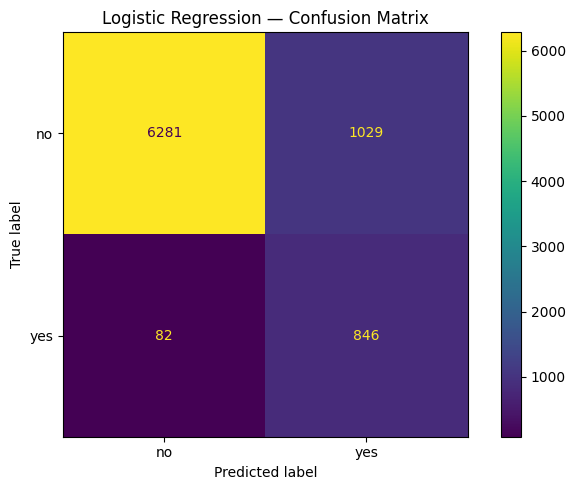


Random Forest — F1: 0.6641
              precision    recall  f1-score   support

           0     0.9672    0.9354    0.9510      7310
           1     0.5959    0.7500    0.6641       928

    accuracy                         0.9145      8238
   macro avg     0.7815    0.8427    0.8076      8238
weighted avg     0.9254    0.9145    0.9187      8238



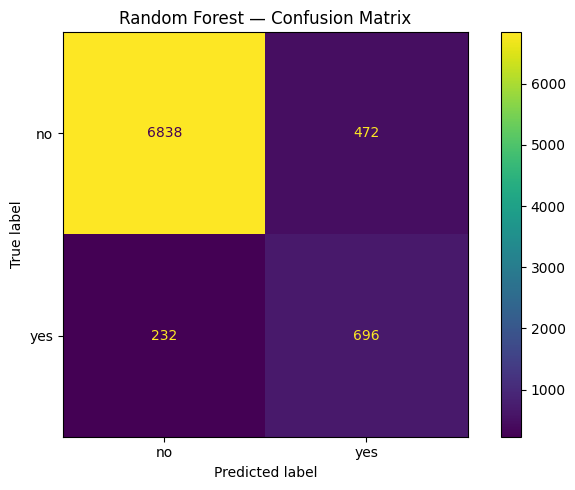

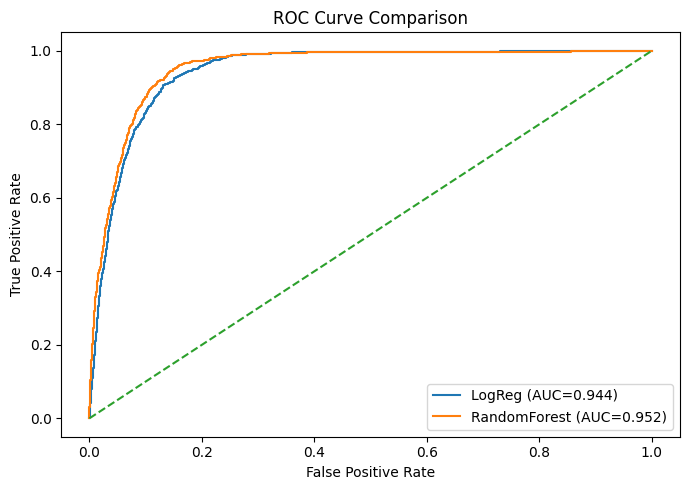

In [16]:
def evaluate_model(name, pipe, X_te, y_te):
    y_pred = pipe.predict(X_te)
    y_prob = pipe.predict_proba(X_te)[:, 1]
    print(f"\n{name} — F1:", round(f1_score(y_te, y_pred), 4))
    print(classification_report(y_te, y_pred, digits=4))
    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    ConfusionMatrixDisplay(cm, display_labels=['no','yes']).plot(values_format='d')
    plt.title(f"{name} — Confusion Matrix"); plt.tight_layout(); plt.show()
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    return fpr, tpr, auc(fpr, tpr)

fpr_lr, tpr_lr, auc_lr = evaluate_model("Logistic Regression", log_reg, X_test, y_test)
fpr_rf, tpr_rf, auc_rf = evaluate_model("Random Forest", rf, X_test, y_test)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={auc_rf:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison"); plt.legend(loc="lower right")
plt.tight_layout(); plt.show()

In [18]:
probs = rf.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.1, 0.9, 33)
best_t, best_f1 = max(((t, f1_score(y_test, (probs >= t).astype(int))) for t in thresholds), key=lambda x: x[1])
print(f"Best threshold for RF: {best_t:.3f}  |  Best F1: {best_f1:.4f}")

Best threshold for RF: 0.475  |  Best F1: 0.6731


In [ ]:
prep = rf.named_steps["prep"]
rf_model = rf.named_steps["clf"]
ohe = prep.named_transformers_["cat"]

ohe_feature_names = list(ohe.get_feature_names_out(cat_cols))
num_feature_names = list(prep.named_transformers_["num"].feature_names_in_)
feature_names = ohe_feature_names + num_feature_names

X_test_trans = prep.transform(X_test)
X_shap = X_test_trans.toarray() if hasattr(X_test_trans, "toarray") else X_test_trans

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap)

# Global importance
shap.summary_plot(shap_values[1], X_shap, feature_names=feature_names, show=True)

# Save 5 individual prediction waterfalls
idxs = np.random.choice(range(X_shap.shape[0]), size=5, replace=False)
for i, idx in enumerate(idxs, start=1):
    exp = shap.Explanation(
        values=shap_values[1][idx],
        base_values=explainer.expected_value[1],
        data=X_shap[idx],
        feature_names=feature_names
    )
    plt.figure()
    shap.plots.waterfall(exp, max_display=15, show=False)
    plt.tight_layout()
    plt.savefig(f"shap_waterfall_{i}.png", dpi=160)
    plt.close()

    print("Saved: shap_waterfall_1.png ... shap_waterfall_5.png")
#               

In [12]:
import os
print('current folder:', os.getcwd())

current folder: C:\Users\HP
